In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/videogamesales/vgsales.csv


In [2]:
# Loading the data
videogame_sales_path = '/kaggle/input/videogamesales/vgsales.csv'
sale_data = pd.read_csv(videogame_sales_path, index_col='Rank')
sale_data.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [3]:
sale_data.shape

(16598, 10)

In [4]:
sale_data.describe

<bound method NDFrame.describe of                                                    Name Platform    Year  \
Rank                                                                       
1                                            Wii Sports      Wii  2006.0   
2                                     Super Mario Bros.      NES  1985.0   
3                                        Mario Kart Wii      Wii  2008.0   
4                                     Wii Sports Resort      Wii  2009.0   
5                              Pokemon Red/Pokemon Blue       GB  1996.0   
...                                                 ...      ...     ...   
16596                Woody Woodpecker in Crazy Castle 5      GBA  2002.0   
16597                     Men in Black II: Alien Escape       GC  2003.0   
16598  SCORE International Baja 1000: The Official Game      PS2  2008.0   
16599                                        Know How 2       DS  2010.0   
16600                                  Spirits & Spell

### Problem?
This will be a regression model as I need to predict the global_sales for different games based on the other attributes.
In order to prevent data leakages, I will need to get rid of the Rank, and all the sales columns, as they are directly tied to the global_sales value. Additionally, I wouldn't have any of that data for a game that hasn't been published yet.

### Dealing with NaNs

In [5]:
sale_data.isna().sum()

Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

There aren't too many NaNs in publisher, so I will drop them. Additionally, some of them coincide with the missing value for year so dropping them will be helpful. Imputing them wouldn't give an accurate value since its a categorical variable, and it doesn't really have any order so it could make some innacurate conclusions based on the imputer.

In [6]:
sale_data.dropna(subset=['Publisher'], axis=0, inplace=True)
sale_data.dropna(subset=['Name'], axis=0, inplace=True)

### Identifying categorical variables

In [7]:
# Get list of categorical variables
s = (sale_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Name', 'Platform', 'Genre', 'Publisher']


### Graphing the different categorical variables
Overall, in the graphs, it can be seen that there are a ton of outliers. The data is all very concentrated to low sales but there are quite a lot of outliers. Overall the quality of the data is quite low as there aren't enough variables ot make an accurate prediction is my guess.

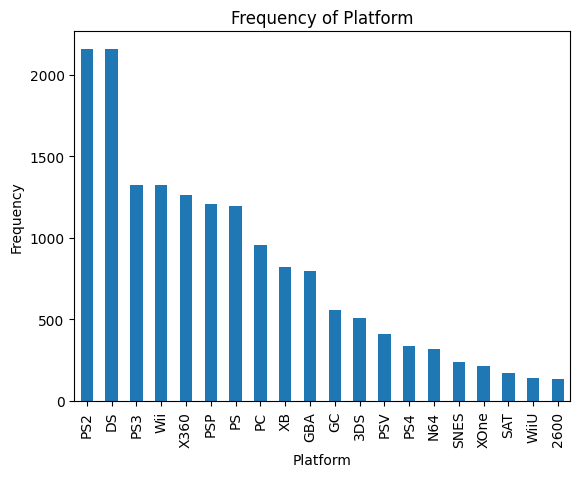

In [8]:
frequency = sale_data['Platform'].value_counts().head(20)
plt.figure()
frequency.plot(kind='bar')
plt.title('Frequency of Platform')
plt.xlabel('Platform')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

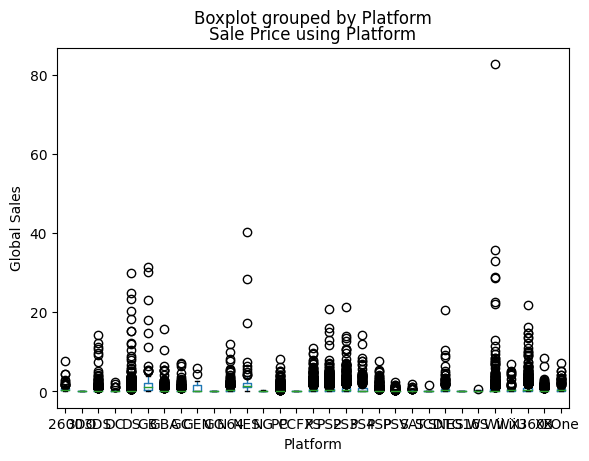

In [9]:
# Create the box plot
plt.figure(figsize=(10,6))
sale_data.boxplot(column='Global_Sales', by='Platform', grid=False)

# Adding labels and title
plt.title('Sale Price using Platform')
plt.xlabel('Platform')
plt.ylabel('Global Sales')

# Display the plot
plt.show()

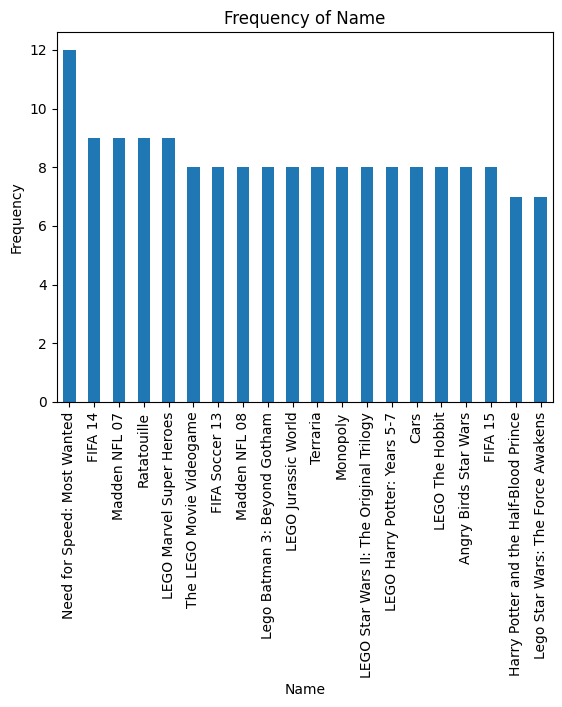

In [10]:
frequency = sale_data['Name'].value_counts().head(20)
plt.figure()
frequency.plot(kind='bar')
plt.title('Frequency of Name')
plt.xlabel('Name')
plt.ylabel('Frequency')
plt.show()

This is interesting to me since I didn't think there would be duplicates for name. In the end, the presence of duplicates makes it a possibility to include name for the model as it isn't just a useless identifier.

In [11]:
#Takes a really long time to run

# # Create the box plot
# plt.figure(figsize=(10,6))
# sale_data.boxplot(column='Global_Sales', by='Name', grid=False)

# # Adding labels and title
# plt.title('Sale Price using Name')
# plt.xlabel('Name')
# plt.ylabel('Global Sales')

# # Display the plot
# plt.show()

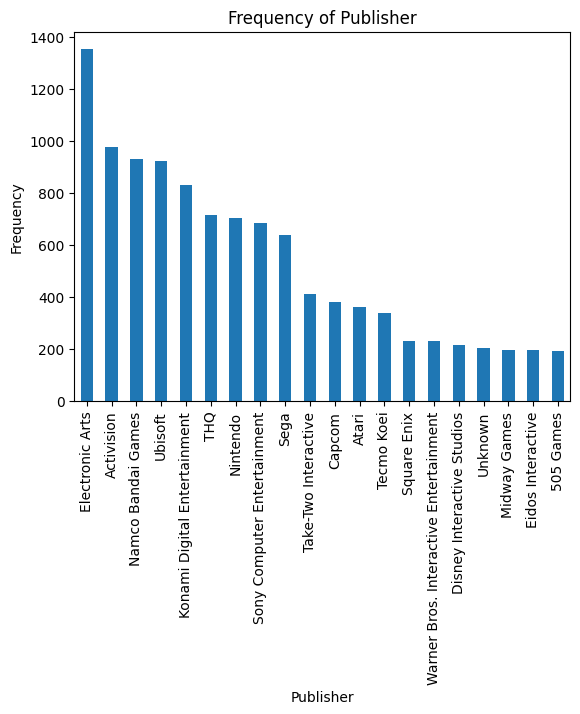

In [12]:
frequency = sale_data['Publisher'].value_counts().head(20)
plt.figure()
frequency.plot(kind='bar')
plt.title('Frequency of Publisher')
plt.xlabel('Publisher')
plt.ylabel('Frequency')
plt.show()

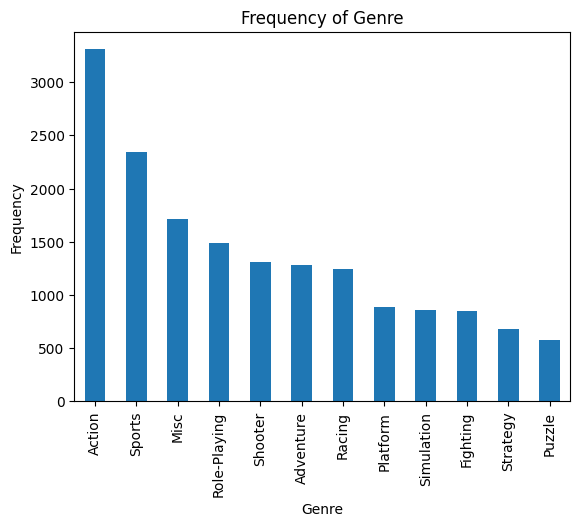

In [13]:
frequency = sale_data['Genre'].value_counts()
plt.figure()
frequency.plot(kind='bar')
plt.title('Frequency of Genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

There aren't many different unique entries for genre, so I could one hot it to make the model more accurate.

In [14]:
sale_data.Platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

### Preparing a OneHotEncoder for genre
There aren't too many entries for genre so it could help the accuracy. I am making 2 models in this case, one with the oneHotEncoding and getting rid of the publisher columns that had NaNs, and another that doesn't and only uses ordinal encoding. I expect the OneHot to be more accurate

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical columns
one_hot_encoded = encoder.fit_transform(sale_data[['Genre']])
onehot_sale_data_encoded = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(['Genre']))
onehot_sale_data = pd.concat([sale_data.drop(['Genre'], axis=1), onehot_sale_data_encoded], axis=1)

In [16]:
onehot_sale_data.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
count,16291.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000
mean,2006.405561,0.265079,0.146883,0.077998,0.048191,0.538426,0.200060,0.077509,0.051149,0.103507,0.053446,0.035127,0.075453,0.089843,0.079081,0.052177,0.141657,0.040992
std,5.832412,0.817929,0.506129,0.309800,0.188879,1.557424,0.400057,0.267406,0.220308,0.304629,0.224928,0.184106,0.264130,0.285965,0.269873,0.222390,0.348708,0.198277
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preparing ordinal encoder
Here is where I start the data manipulation for the second dataset/model

In [17]:
from sklearn.preprocessing import OrdinalEncoder

label_sale_data = onehot_sale_data.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_sale_data[['Name', 'Platform', 'Publisher']] = ordinal_encoder.fit_transform(onehot_sale_data[['Name', 'Platform', 'Publisher']])

#### Second dataset/model starts here

In [18]:
label_sale_data2 = sale_data.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_sale_data2[object_cols] = ordinal_encoder.fit_transform(sale_data[object_cols])

In [19]:
print("Category to Label Mapping:")
print(ordinal_encoder.categories_)

Category to Label Mapping:
[array(["'98 Koshien", '.hack//G.U. Vol.1//Rebirth',
       '.hack//G.U. Vol.2//Reminisce', ..., 'uDraw Studio',
       'uDraw Studio: Instant Artist', '¡Shin Chan Flipa en colores!'],
      dtype=object), array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object), array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object), array(['10TACLE Studios', '1C Company', '20th Century Fox Video Games',
       '2D Boy', '3DO', '49Games', '505 Games', '5pb', '7G//AMES',
       '989 Sports', '989 Studios', 'AQ Interactive', 'ASC Games',
       'ASCII Entertainment', 'ASCII Media Works', 'ASK', 'Abylight',
       'Acclaim Entertainment', 'Accolade', 'Ackkstudios',

#### Adding back year column as it got removed

In [20]:
label_sale_data['Year'] = onehot_sale_data["Year"]

### Setting up a simple imputer for the 2 datasets/models

In [21]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
my_imputer = SimpleImputer() # Your code here
imputed_sale_data = pd.DataFrame(my_imputer.fit_transform(label_sale_data))

# Fill in the lines below: imputation removed column names; put them back
imputed_sale_data.columns = label_sale_data.columns

In [22]:
imputed_sale_data2 = pd.DataFrame(my_imputer.fit_transform(label_sale_data2))

# Fill in the lines below: imputation removed column names; put them back
imputed_sale_data2.columns = label_sale_data2.columns

In [23]:
imputed_sale_data.isna().sum()

Name                  0
Platform              0
Year                  0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Genre_Action          0
Genre_Adventure       0
Genre_Fighting        0
Genre_Misc            0
Genre_Platform        0
Genre_Puzzle          0
Genre_Racing          0
Genre_Role-Playing    0
Genre_Shooter         0
Genre_Simulation      0
Genre_Sports          0
Genre_Strategy        0
dtype: int64

In [24]:
imputed_sale_data2.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

In [25]:
imputed_sale_data.describe()

,Name,Platform,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Genre_Action,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
count,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,...,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000,16599.000000
mean,5767.324486,15.816505,2006.405561,293.608767,0.265079,0.146883,0.077998,0.048191,0.538426,0.200060,...,0.051149,0.103507,0.053446,0.035127,0.075453,0.089843,0.079081,0.052177,0.141657,0.040992
std,3303.293228,8.375281,5.778044,177.289864,0.816474,0.505229,0.309249,0.188543,1.554653,0.399346,...,0.219916,0.304087,0.224528,0.183779,0.263660,0.285456,0.269393,0.221994,0.348088,0.197924
min,0.000000,0.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2904.000000,7.000000,2003.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5795.000000,16.000000,2007.000000,323.000000,0.080000,0.020000,0.000000,0.010000,0.170000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8648.500000,21.000000,2010.000000,456.000000,0.240000,0.110000,0.040000,0.040000,0.480000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11441.000000,30.000000,2020.000000,577.000000,41.490000,29.020000,10.220000,10.570000,82.740000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
imputed_sale_data2.describe()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000,16540.000000
mean,5767.324486,15.816505,2006.405561,4.931076,293.608767,0.265079,0.146883,0.077998,0.048191,0.538426
std,3309.179944,8.390206,5.788341,3.763517,177.605808,0.817929,0.506129,0.309800,0.188879,1.557424
min,0.000000,0.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2903.000000,7.000000,2003.000000,1.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,5814.500000,16.000000,2007.000000,5.000000,323.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,8661.250000,21.000000,2010.000000,8.000000,457.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,11441.000000,30.000000,2020.000000,11.000000,577.000000,41.490000,29.020000,10.220000,10.570000,82.740000


### Splitting data for the models

In [27]:
y = imputed_sale_data.Global_Sales
imputed_sale_data.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1, inplace=True)

features = list(imputed_sale_data.columns)
X = imputed_sale_data[features]



In [28]:
y2 = sale_data.Global_Sales
imputed_sale_data2.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1, inplace=True)

features2 = list(imputed_sale_data2.columns)
X2 = imputed_sale_data2[features2]

In [29]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [30]:
# Break off validation set from training data
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, train_size=0.8, test_size=0.2,
                                                      random_state=0)

### Using RandomForestRegressor for the models

In [31]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, criterion='poisson')
model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0, criterion='poisson')

In [32]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=0, max_depth=10)
dt_model2 = DecisionTreeRegressor(random_state=0, max_depth=10)

In [33]:
model.fit(X_train, y_train)
model2.fit(X_train2, y_train2)
dt_model.fit(X_train, y_train)
dt_model2.fit(X_train2, y_train2)

DecisionTreeRegressor(max_depth=10, random_state=0)

# Random Forest

### First Model

In [34]:
from sklearn.metrics import mean_absolute_error

# Generate test predictions
train_test = model.predict(X_train)
preds_test = model.predict(X_valid)

# Score
print(mean_absolute_error(y_train, train_test))
print(mean_absolute_error(y_valid, preds_test))

0.39590316940368053
0.4731029330813595


### Second Model

In [35]:
# Generate test predictions
train_test2 = model2.predict(X_train2)
preds_test2 = model2.predict(X_valid2)

# Score
print(mean_absolute_error(y_train2, train_test2))
print(mean_absolute_error(y_valid2, preds_test2))

0.3723805427619297
0.4612581068927628


# Decision Tree

In [36]:
# Generate test predictions
dt_train_test = dt_model.predict(X_train)
dt_preds_test = dt_model.predict(X_valid)

# Score
print(mean_absolute_error(y_train, dt_train_test))
print(mean_absolute_error(y_valid, dt_preds_test))

0.37006667964606843
0.49336049909224605


In [37]:
# Generate test predictions
dt_train_test2 = dt_model2.predict(X_train2)
dt_preds_test2 = dt_model2.predict(X_valid2)

# Score
print(mean_absolute_error(y_train2, dt_train_test2))
print(mean_absolute_error(y_valid2, dt_preds_test2))

0.3823993781932484
0.4821948510965933


### # Results
#### RANDOM FOREST
Both of the models seem to be overfitting a lot. There is an around 100000 dollar gap in between the train and validation for the second model, and a 95000 dollar gap for the first model. The accuracy is very poor, both of the models are around 500000 dollars off in the predictions for the validation and slightly less for the training. Surprisingly enough, the second model was more accurate, the one without the oneHotEncoding. I didn't expect this really and I'm not sure why this happened, maybe after graphing the model interpretation I could get some more insight as to why this happened.
#### DECISION TREE
Overall, decision tree had worse accuracy. The overfitting was the worst on the first model for decision tree.

#### HYPERPARAMETERS
After testing with different hyperparameters, I found that a n_estimators of 100 gave the best results, and a max_depths of 10 gave the best. The overfitting got worse and worse the deeper it went.

# Model Interpretation

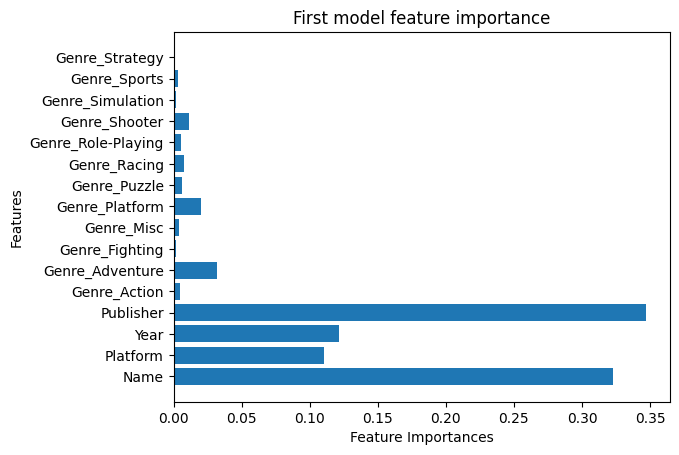

In [38]:
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
features = np.array(X_train.columns)

plt.barh(features, feature_importances)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("First model feature importance")
plt.show()

### RandomForest Notes
The genres that had more importance wasn't those that we had more data for, showing a strange relationship. Publisher was the most important identifier, which makes sense since a more well known publisher would have more consistent success than an indie developer. Name was also very important, probably due to a similar reason. Games with the same names would have similar amounts of sales, from console to console. Year was relatively important, much older games wouldn't sell as well. Platform was the least important besides genre.

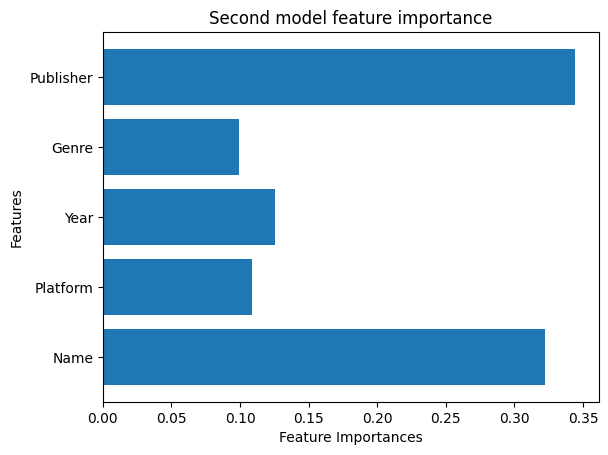

In [39]:
import matplotlib.pyplot as plt
feature_importances = model2.feature_importances_
features = np.array(X_train2.columns)

plt.barh(features, feature_importances)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("Second model feature importance")
plt.show()

### RandomForest Notes
Similar to the previous model excepte genre is all together. Genre was the least important, regardless of whether it was split apart or not. Besides for that it is nearly identical.

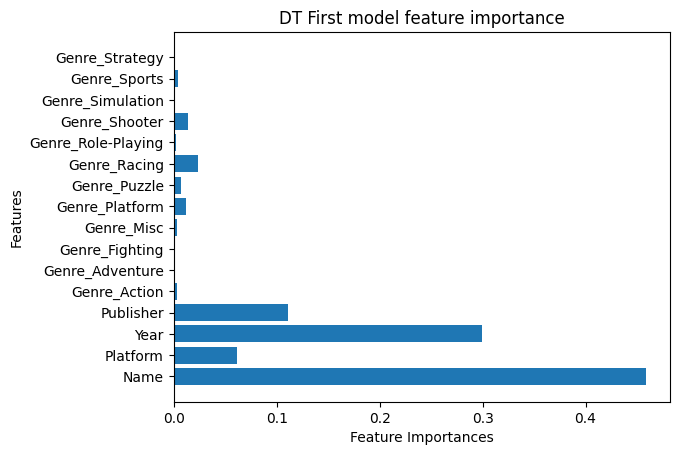

In [40]:
import matplotlib.pyplot as plt
feature_importances = dt_model.feature_importances_
features = np.array(X_train.columns)

plt.barh(features, feature_importances)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("DT First model feature importance")
plt.show()

### DecisionTree Notes
Here, it can be seen that name is the most important feature, over publisher from before and with much more importance than on the randomForests. Publisher is much less important for the DecisionTree than it was for the randomForests, and year strangely enough was the second most important. For the genres, platform wasn't as important as it was in the randomForest.

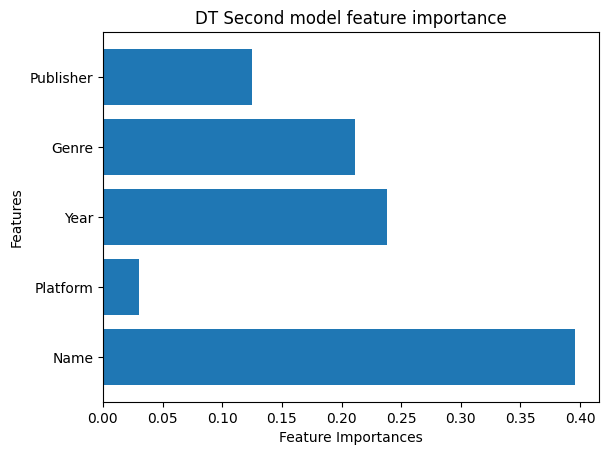

In [41]:
import matplotlib.pyplot as plt
feature_importances = dt_model2.feature_importances_
features = np.array(X_train2.columns)

plt.barh(features, feature_importances)
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("DT Second model feature importance")
plt.show()

### DecisionTree Notes
Genre had much more importance in this graph compared to all the rest. Like the other decision tree, it is name that is the most important. Platform has incredibly small significance compared to all the other models, and publisher is also quite low similar to the other DecisionTree model

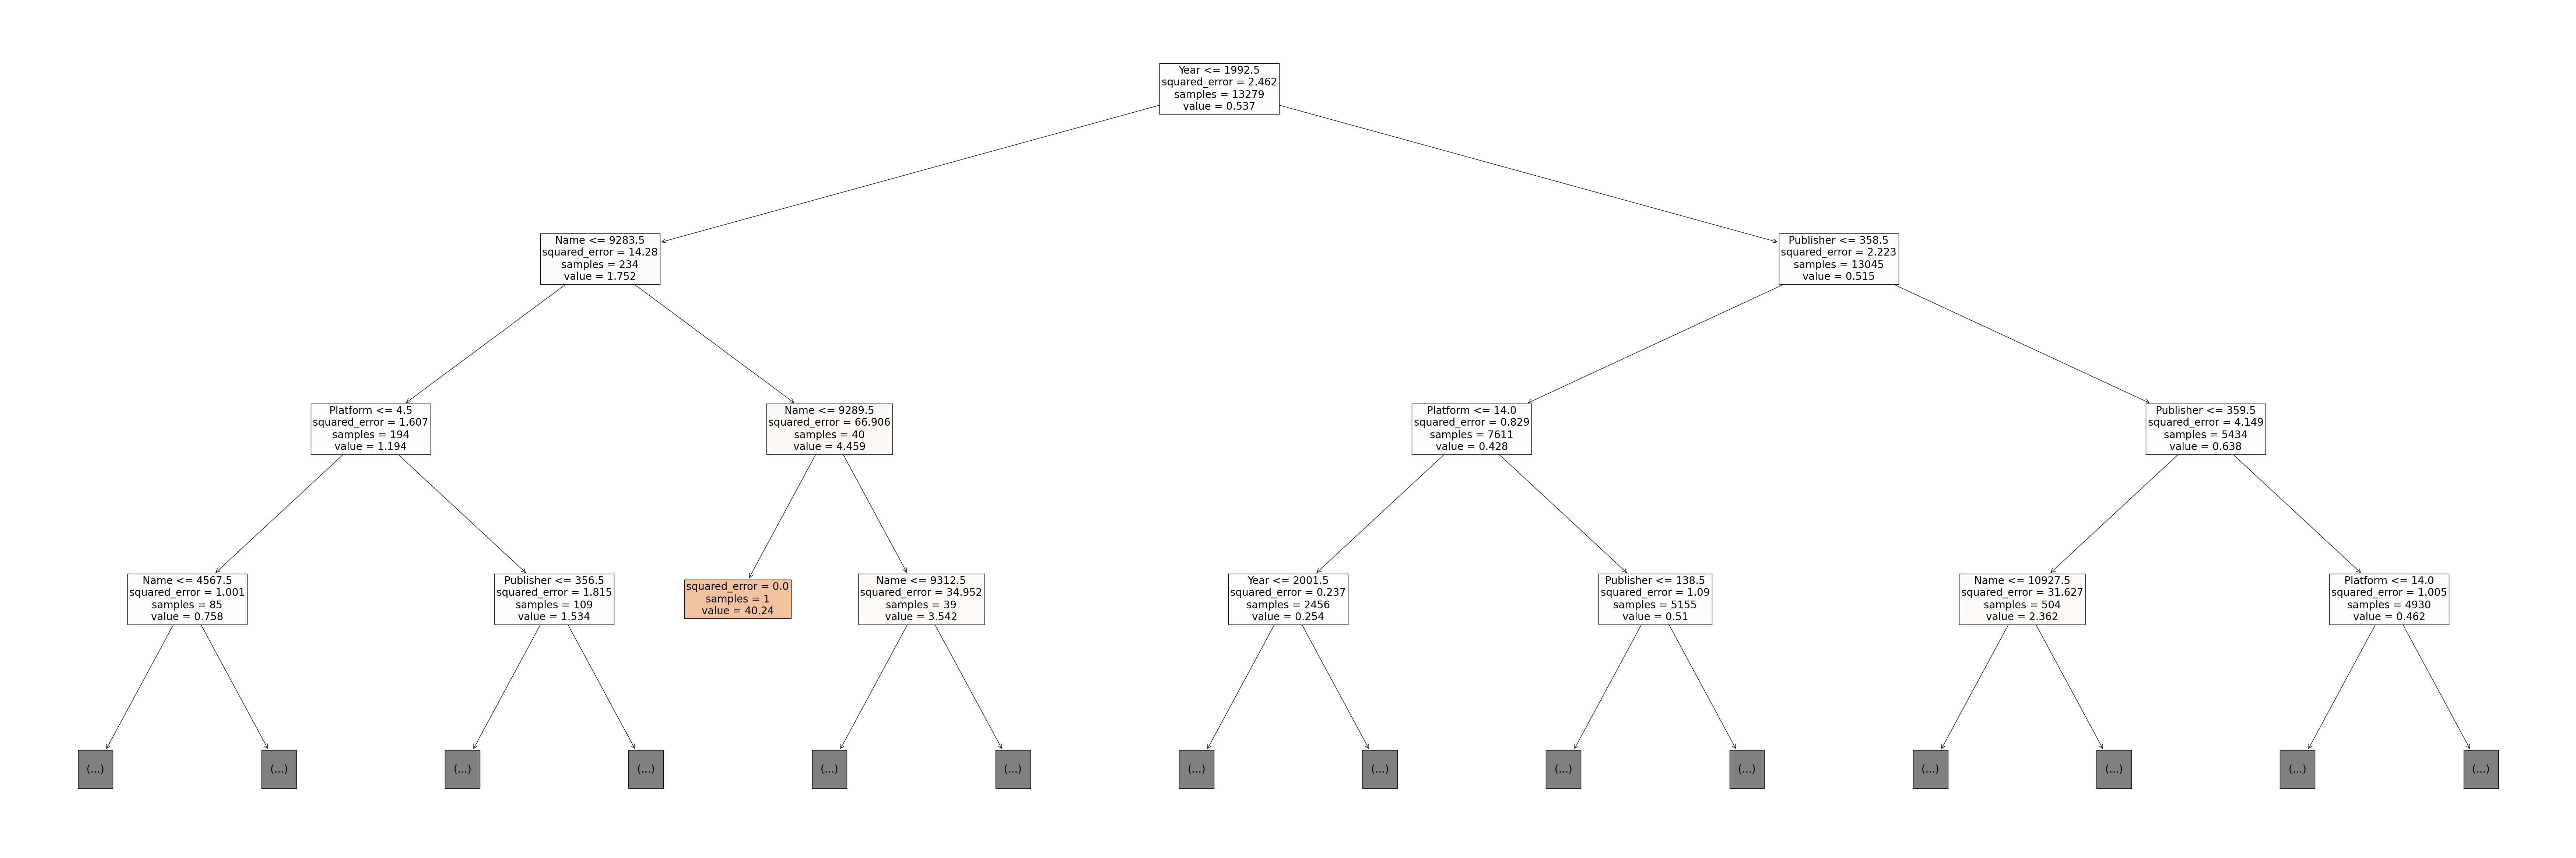

In [42]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(90, 30))
tree.plot_tree(dt_model, feature_names=X_train.columns, filled=True,impurity=True,  fontsize=20, max_depth=3)
plt.show()

### DecisionTree Visualiser
Here I can see the general process it follows, checking the year, then the name, followed by platform then publisher, after which it continues.

### Bonus
I am going to make an XGBoost model for the bonus

In [43]:
from xgboost import XGBRegressor

xgbModel = XGBRegressor(n_estimators=100, max_depth=10)
xgbModel2 = XGBRegressor(n_estimators=100, max_depth=10)

xgbModel.fit(X_train, y_train)
xgbModel2.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
xgb_train_test = xgbModel.predict(X_train)
xgb_preds_test = xgbModel.predict(X_valid)


print(mean_absolute_error(y_train, xgb_train_test))
print(mean_absolute_error(y_valid, xgb_preds_test))

0.09458644317434636
0.5330469348672013


In [45]:
xgb_train_test2 = xgbModel2.predict(X_train2)
xgb_preds_test2 = xgbModel2.predict(X_valid2)


print(mean_absolute_error(y_train2, xgb_train_test2))
print(mean_absolute_error(y_valid2, xgb_preds_test2))

0.09485387893863273
0.45176340976045765


### Notes
Using the same hyperparameters as for the RandomForest models, it canbe seen that the XGBoost models have much much worse overfitting but super hightened accuracy for the training data. The first model, with the genres oneHot has a really bad validation score showing it to be the least accurate model of all, while the second model has the best validation score out of all the models at +-451763 avg. Of course it is still super innacurate but it has given me the best results.